In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

**Torch, Numpy stuff**

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device.type)

# ---

torch.manual_seed(42)
np.random.seed(42)

cuda


---
**Training Data**

Demonstration data contains a list of **d** scenes:

- ~~Each scene contains a list of trajectories of **p** people, where p is **not constant**~~
- A trajectory is a list of **t** states, where t = 400
- A state is a **s** = 4 dimensional variable
 - State = (d<sub>goal<sub>x</sub></sub>, d<sub>goal<sub>y</sub></sub>, v<sub>x</sub>, v<sub>y</sub>)
    
> Shape of data is (d, ~~p,~~ t, s) => (d, ~~p,~~ 400, 4)

---

Train, test, val split: 0.8, 0.01, 0.19

In [24]:
from sklearn.model_selection import train_test_split

def data_from_demonstrations(obs_dims=[0,1], tar_dims=[2,3], path="../data/input/"):
    data = np.load(f"{path}/states_processed.npy")
    X, Y = data[:,:,:,obs_dims], data[:,:,:,tar_dims]
    return X, Y


# for testing purposes
def synthetic_data(n=10):
    tlen = 400
    X = np.zeros((n, tlen, 1))
    Y = np.zeros((n, tlen, 1))
    for i in range(n):
        X[i] = np.random.uniform(0, 1, tlen).reshape(tlen, 1)
        Y[i] = np.sin(X[i]*2*np.pi)/n + i/n
    return X, Y

#X, Y = data_from_demonstrations()
X, Y = synthetic_data()

X_train, X_rem, Y_train, Y_rem = train_test_split(X, Y, train_size=0.8)

# 0.2 * 0.05 = 0.01 (test size in entire data)
test_sz = 0.05
X_val, X_test, Y_val, Y_test = train_test_split(X_rem, Y_rem, test_size=test_sz)

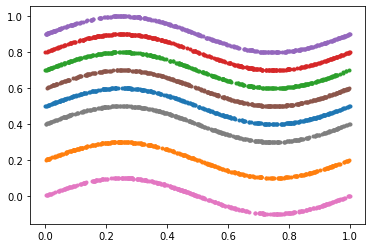

In [25]:
import matplotlib.pyplot as plt

def plot_trajectories(X, Y):
    d, t, s = X.shape
    for i in range(d):
        plt.plot(X[i], Y[i], ".")


plot_trajectories(X_train, Y_train)

---
**n <= n<sub>max</sub>** random number of random observations on a random trajectory

In [39]:
n_max = 10

def sample_training_batch():
    d, t, s = X_train.shape
    
    rand_traj_ind = np.random.randint(0, d)
    rand_traj = X_train[rand_traj_ind]
    rand_out = Y_train[rand_traj_ind]

    n = np.random.randint(1, n_max+1)
    observation_indices = np.random.choice(np.arange(t), n+1, replace=False) # n+1: +1 is for sampling the target
    # TODO: match these ind with frames
    # TODO: frames to CNN
    observations = np.stack((rand_traj[observation_indices[:-1], :], rand_out[observation_indices[:-1], :]), axis=-1)
    targetX, targetY = rand_traj[observation_indices[-1], :], rand_out[observation_indices[-1], :]
    
    return observations, targetX, targetY

---
**Model**

In [ ]:
class CNP(nn.module):
    def __init__(self, nof_channels):
        super(CNP, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
            nn.MaxPool2d(2, 2)
            nn.Conv2d(6, 16, 5)
            nn